In [5]:
pip install torch torchvision matplotlib pillow



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Step 0, Total Loss: 21188388.0
Step 50, Total Loss: 15444804.0
Step 100, Total Loss: 11661078.0
Step 150, Total Loss: 7925977.0
Step 200, Total Loss: 4694114.0
Step 250, Total Loss: 2608563.25


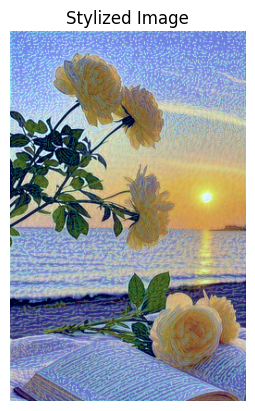

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image loader
def load_image(path, max_size=400):
    image = Image.open(path).convert('RGB')
    
    size = max(image.size)
    if size > max_size:
        scale = max_size / size
        size = tuple([int(dim * scale) for dim in image.size])
        image = image.resize(size, Image.Resampling.LANCZOS)
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x[:3, :, :]),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))
    ])
    
    image = transform(image).unsqueeze(0)
    return image.to(device)

# Image unloader
def im_convert(tensor):
    image = tensor.clone().detach().cpu().squeeze(0)
    image = image * torch.tensor((0.229, 0.224, 0.225)).view(3,1,1)
    image = image + torch.tensor((0.485, 0.456, 0.406)).view(3,1,1)
    image = image.clamp(0, 1)
    return transforms.ToPILImage()(image)

# Load images
content = load_image("/Users/sanjayjangid/Desktop/picccc.png")
style = load_image("/Users/sanjayjangid/Downloads/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg.webp")

# Load VGG19 pre-trained model
vgg = models.vgg19(pretrained=True).features.to(device).eval()

# Freeze parameters
for param in vgg.parameters():
    param.requires_grad_(False)

# Define layers to use
def get_features(image, model, layers=None):
    if layers is None:
        layers = {
            '0': 'conv1_1',  
            '5': 'conv2_1',
            '10': 'conv3_1', 
            '19': 'conv4_1', 
            '21': 'conv4_2',  # Content layer
            '28': 'conv5_1'
        }
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

# Gram Matrix for style
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    return torch.mm(tensor, tensor.t())

# Get features
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Target image
target = content.clone().requires_grad_(True).to(device)

# Style and content weights
style_weights = {
    'conv1_1': 1.0,
    'conv2_1': 0.8,
    'conv3_1': 0.5,
    'conv4_1': 0.3,
    'conv5_1': 0.1
}
content_weight = 1e4
style_weight = 1e2

# Optimizer
optimizer = optim.Adam([target], lr=0.003)

# Training loop
steps = 300
for i in range(steps):
    target_features = get_features(target, vgg)
    
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        style_loss += layer_loss / (target_feature.shape[1]**2)

    total_loss = content_weight * content_loss + style_weight * style_loss
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if i % 50 == 0:
        print(f"Step {i}, Total Loss: {total_loss.item()}")

# Show result
final_img = im_convert(target)
plt.imshow(final_img)
plt.axis('off')
plt.title("Stylized Image")
plt.show()

# Save result
final_img.save("stylized_output.jpg")
